# Метод статистической деконволюции

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from random import random

In [2]:
from modules_reloader import reloader
from modules import randomized_ir, utils, plots, mcmc
relmod = reloader(randomized_ir, utils, plots, mcmc)

In [3]:
SAVE_IMAGES = True

## IR

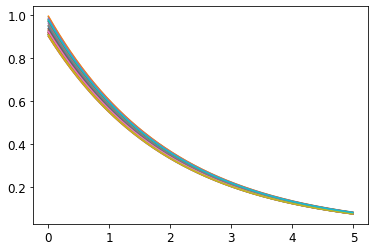

In [4]:
L_true = 4.99
pts_per_bin = 100

ir_x = np.linspace(0, L_true, int(L_true * pts_per_bin))

# exp-decay
gamma = 0.5
ir_y = np.exp(- gamma * ir_x)

# step
# step_width = 3
# step_start = 0
# ir_y = (np.logical_and(ir_x > step_start, ir_x <= step_start+step_width)).astype('float')

# gaussian shape
# x_max = 1
# x_sigma = 1
# ir_y = np.exp(- (ir_x - x_max) ** 2 / (2 * x_sigma ** 2))

factor_min, factor_max = 0.9, 1
rir = randomized_ir.RandomizedIr(ir_x, ir_y, factor=lambda: factor_min + random()*(factor_max - factor_min))
# rir = rir.RandomizedIr(ir_x, ir_y)

rir.plot_realizations(count=30)

# Convoluted signal

Pic: `\ref{pic:problem-setup}`


In [5]:
N = 30
n_vec_mean = 15

n_vec = utils.generate_poissonian_ns(n_vec_mean, N)

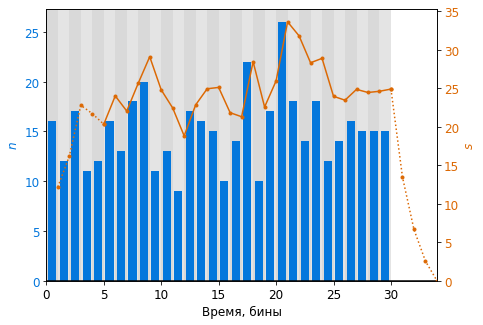

In [6]:
# uniform inbin time distribution:
s_vec = rir.convolve_with_n_vec(n_vec)

# non trivial inbin time distribution:
# S_vec = rir.convolve_with_n_vec(n_vec, inbin_invcdf=lambda x: x**(1/10), debug_inbin_times=True)

filename = 'problem-setup-example' if SAVE_IMAGES else None

f, a = plots.plot_convolution(n_vec, s_vec, filename=filename)

# Mean-based estimation

Chapter: `Грубая оценка методом наименьших квадратов`

In [7]:
rireff = randomized_ir.RandomizedIrEffect(rir, N, samplesize=100000)

L = rireff.L

In [8]:
rireff.explore()

L=4 and N=30
RIR effects from photon in the bin #1 (t in [0; 1]):
t	effect
1	0.75 +/- 0.11
2	0.45 +/- 0.07
3	0.27 +/- 0.04
4	0.17 +/- 0.02
5	0.10 +/- 0.02

C matrix used to calculate mean-vector for a given n vector (with cut edge effects):
[[0.10034606 0.16667211 0.27479586 0.45306178 0.74697259 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.10034606 0.16667211 0.27479586 0.45306178 0.74697259
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.10034606 0.16667211 0.27479586 0.45306178
  0.74697259 0.         0.         0.         0.         0.
  0. 

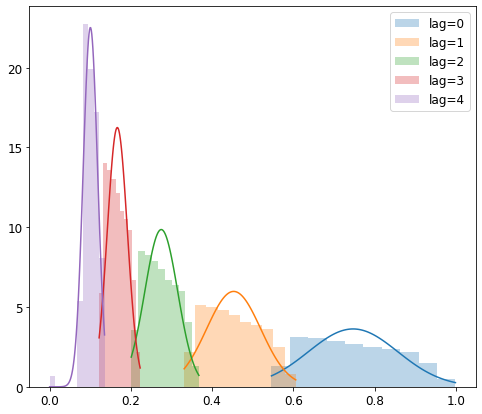

In [9]:
rireff.plot_samples()

In [10]:
n_vec_estimation = rireff.estimate_n_vec(s_vec)

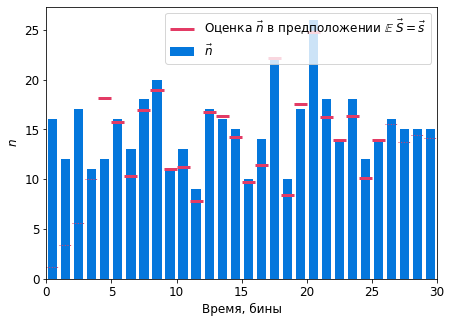

In [11]:
filename = 'mean-estimation' if SAVE_IMAGES else None
f, a = plots.plot_mean_n_estimation(n_vec, n_vec_estimation, L, filename=filename)


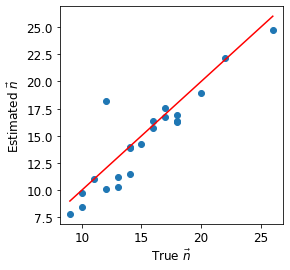

In [12]:
fig, ax = plt.subplots(figsize=(4, 4))

cut_n_vec = n_vec[L:-L]
cut_n_vec_estimation = n_vec_estimation[L:-L]

ax.scatter(cut_n_vec, cut_n_vec_estimation)

n_minmax = np.linspace(cut_n_vec.min(), cut_n_vec.max(), 2)
ax.plot(n_minmax, n_minmax, 'r-')

ax.set_xlabel("True $\\vec{n}$")
ax.set_ylabel("Estimated $\\vec{n}$")

plt.show()

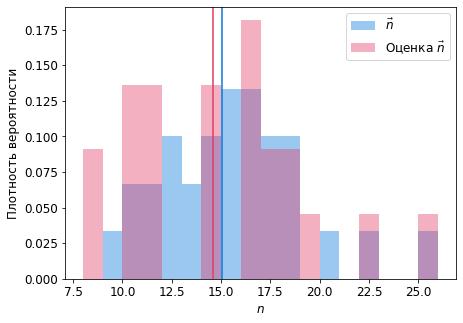

In [13]:
# filename = 'mean-estimation-assessment'
filename = None
f, a = plots.plot_mean_n_estimation_assessment(n_vec, n_vec_estimation, L, filename=filename)

# MCMC-based estimation

In [14]:
s_vec_error = 0.1 * np.ones_like(s_vec, dtype=float)

# loglike = rireff.get_loglikelihood_mvn(s_vec, s_vec_error)
# loglike = rireff.get_loglikelihood_uncorrelated_mvn(s_vec, s_vec_error)
loglike = rireff.get_loglikelihood_independent_normdist(s_vec, s_vec_error)

loglike(n_vec_estimation)

-7.011499421698126

In [15]:
n_vec_min = np.zeros_like(n_vec_estimation, dtype=float)
n_vec_max = n_vec_estimation * 100

def logposterior(n_vec):
    if np.any(np.logical_or(n_vec < n_vec_min, n_vec > n_vec_max)):
        return - np.inf
    return loglike(n_vec)

In [17]:
result = mcmc.run_mcmc(
    logposterior,
    n_vec_estimation,
    L,
    mcmc.SamplingConfig(
        progress_bar=True,
        n_samples=50000,
        n_walkers=128,
        debug_acceptance_fraction_each=None,
        autocorr_estimation_each=5000,
        multiprocessing=True,
    )
)

100%|██████████| 50000/50000 [10:06<00:00, 82.42it/s] 


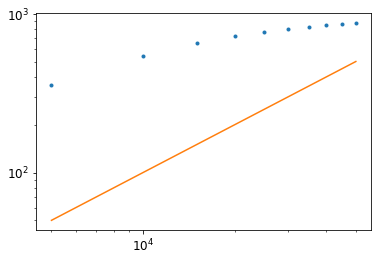

In [18]:
Ns, tau = result.N_tau

Ns = np.array(Ns)
tau = np.array(tau)

plt.plot(Ns, tau, '.')
plt.plot(Ns, Ns / 100, label='N/50')
plt.plot(Ns, Ns / 50, label='N/100')

plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

In [19]:
ind_sample = mcmc.extract_independent_sample(result.sampler)

N/50 = 1000;
tau: [1049.65525625  968.7194381   943.2495998   942.7024748  1115.1640077
 1002.76546147  954.5038548   904.21609007  904.42029936  865.10753683
  861.60431957  880.77281471  872.73922846  859.73163529  901.40233591
  838.90315455  892.27282896  851.96691876  835.18106247  799.94086479
  870.21480384  898.29600753  888.31131462  840.03579873  784.763202
  811.62013446  882.14497812  852.78164296  847.48093357  818.98560089]


In [20]:
ind_sample.shape

(15488, 30)

In [119]:
relmod()

/home/njvh/Documents/Science/sphere/thesis/modules/plots.py:198: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(
/home/njvh/Documents/Science/sphere/thesis/modules/plots.py:198: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  ax.pcolormesh(


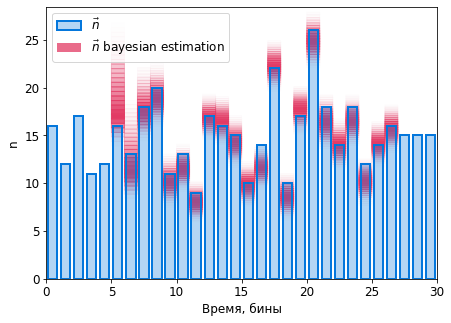

In [120]:
filename = 'bayesian-estimation-result' if SAVE_IMAGES else None
f, a = plots.plot_bayesian_mean_estimation(n_vec, ind_sample, L, filename=filename)

Text(0.5, 0, 'n')

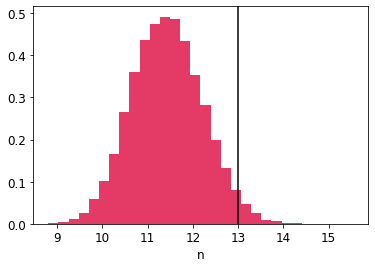

In [127]:
fig, ax =  plt.subplots()

ibin = 10

ax.hist(ind_sample[:, ibin], bins=30, density=True, color='#e33b65')
ax.axvline(n_vec[ibin], color='black')

ax.set_xlabel('n')